#Data collection

In [ ]:
import os
import time
import json
import urllib.request
from SPARQLWrapper import SPARQLWrapper, JSON
from urllib.error import HTTPError

# URL de l'endpoint SPARQL de Wikidata
endpoint_url = "https://query.wikidata.org/sparql"
image_data = {}

# Fonction pour générer une requête SPARQL pour une entité Wikidata donnée (par défaut Q144/Dog)
# La requête récupère les items, leurs labels et les URLs des images associées
def query(wd, limit=10):
    return f"""
    SELECT ?item ?itemLabel ?pic
    WHERE {{
      ?item wdt:P31 wd:{wd}.
      ?item wdt:P18 ?pic.
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
    }}
    LIMIT {limit}
    """

# Fonction pour exécuter la requête SPARQL et obtenir les résultats en format JSON
# Implémente une logique de reprise pour gérer les erreurs '429 Too Many Requests'
def get_results(endpoint_url, query):
    user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

# Fonction pour créer un dossier pour stocker les images si celui-ci n'existe pas déjà
def create_directory(name='images'):
    if name not in os.listdir():
        os.mkdir(name)
    else:
        print(f'Dossier {name} déjà existant !')

# Fonction pour vérifier si un dossier est vide (pour éviter de télécharger des images déjà présentes)
def is_directory_empty(name='images'):
    return len(os.listdir(name)) == 0

# Fonction pour ajouter les données d'image dans le dictionnaire image_data pour une entité Wikidata donnée
# Télécharge les images et remplit image_data avec les informations pertinentes
def add_images_for_entity(entity_id, limit):
    results = get_results(endpoint_url, query(entity_id, limit))
    for result in results['results']['bindings']:
        image_name = result['item']['value'].split("/")[-1] + "-" + entity_id  # Nom de l'image téléchargée
        image_data[image_name] = {}
        download_image(result['pic']['value'], image_name)

# Fonction pour ajouter des images pour plusieurs entités Wikidata spécifiées
def add_all_images(entity_ids, limit):
    for entity_id in entity_ids:
        add_images_for_entity(entity_id, limit)

# Fonction pour télécharger une image depuis une URL et l'enregistrer sous un nom donné
def download_image(url, image_name='img0'):
    full_path = f'images/{image_name}.jpg'
    urllib.request.urlretrieve(url, full_path)
    time.sleep(1)

# Fonction pour initialiser image_data avec les informations des images déjà téléchargées
def initialize_already_downloaded_images(folder_name='images'):
    for image in os.listdir(folder_name):
        image_data[image.split(".")[0]] = {}

# Fonction principale pour télécharger toutes les images pour les entités Wikidata spécifiées
# Vérifie si les images ont déjà été téléchargées pour éviter la redondance
def download_images_for_all_entities(entity_ids=['Q144'], limit=5):
    create_directory()
    if not is_directory_empty():
        print('Les images ont déjà été téléchargées !')
        initialize_already_downloaded_images()
        return False
    add_all_images(entity_ids, limit)
    return True

# Entités Wikidata pour lesquelles télécharger les images (ici, 'Q3305213' pour la peinture)
entities_to_download = ['Q3305213','Q144']
download_images_for_all_entities(entity_ids=entities_to_download, limit=5)

# Afficher les données des images téléchargées
print(image_data)


{'Q208758-Q3305213': {}, 'Q210277-Q3305213': {}, 'Q211293-Q3305213': {}, 'Q212616-Q3305213': {}, 'Q219271-Q3305213': {}, 'Q20818014-Q144': {}, 'Q20818039-Q144': {}, 'Q21002362-Q144': {}, 'Q21002371-Q144': {}, 'Q21978595-Q144': {}}


In [3]:
import os
import json
from PIL import Image
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import webcolors

# Dictionnaire global image_data déjà défini ailleurs

# Supprime une image du dossier 'images'
def delete_image(file_name):
    file_path = os.path.join("images", file_name)
    if os.path.isfile(file_path):
        os.remove(file_path)
        print(f"L'image {file_name} a été supprimée.")
    else:
        print(f"Impossible de trouver le fichier {file_name}")

# Récupère les métadonnées d'une image
def get_image_metadata(file_name, image_file):
    DATE_TAG = 36867
    MODEL_TAG = 272
    
    image_data[file_name].update({
        'size': classify_image_size(image_file.size),
        'orientation': determine_image_orientation(image_file.size),
        'format': image_file.format,
        'colors': identify_dominant_colors(image_file)
    })
    
    exif_data = image_file._getexif()
    if exif_data:
        image_data[file_name]['date'] = exif_data.get(DATE_TAG, "Unknown")
        image_data[file_name]['model'] = exif_data.get(MODEL_TAG, "Unknown")

# Détermine l'orientation de l'image
def determine_image_orientation(size):
    width, height = size
    if width > height:
        return "landscape"
    elif height > width:
        return "portrait"
    return "squared"

# Catégorise la taille de l'image
def classify_image_size(size):
    width, height = size
    area = width * height
    if area > 1920 * 1080:
        return "large"
    elif area < 640 * 480:
        return "small"
    return "medium"

# Identifie les couleurs dominantes de l'image avec KMeans
def identify_dominant_colors(image_file, num_clusters=2, n_init=1):
    try:
        image_file = image_file.resize((image_file.width // 2, image_file.height // 2))
        image_array = np.array(image_file)
        image_vector = image_array.reshape(-1, 3)
        
        clusters = MiniBatchKMeans(n_clusters=num_clusters, n_init=n_init, random_state=69).fit(image_vector)
        return [tuple(map(int, center)) for center in clusters.cluster_centers_]
    except Exception as e:
        print(f"Erreur lors de l'extraction des couleurs: {e}")
        return []

# Convertit une couleur RGB en nom de couleur le plus proche
def convert_rgb_to_name(rgb):
    try:
        return webcolors.rgb_to_name(rgb)
    except ValueError:
        min_diff, closest_color = float('inf'), None
        for name, hex_value in webcolors.CSS3_NAMES_TO_HEX.items():
            r, g, b = webcolors.hex_to_rgb(hex_value)
            diff = sum([(r - rgb[0]) ** 2, (g - rgb[1]) ** 2, (b - rgb[2]) ** 2])
            if diff < min_diff:
                min_diff, closest_color = diff, name
        return closest_color

# Ouvre une image et extrait ses métadonnées
def process_image_metadata(file_name):
    try:
        with Image.open("images/" + file_name) as img_file:
            file_name = file_name.split(".")[0]
            get_image_metadata(file_name, img_file)
        img_file.close()
        return True
    except FileNotFoundError:
        print(f"Fichier introuvable: {file_name}")
    except Exception as e:
        print(f"Erreur avec l'image {file_name}: {e}")
        delete_image(file_name)
    return False

# Extrait les métadonnées de toutes les images d'un dossier
def process_all_images(directory='images'):
    if not os.path.exists(directory):
        print(f"Le dossier '{directory}' n'existe pas.")
        return
    
    for image in os.listdir(directory):
        if image.lower().endswith((".png", ".jpg", ".jpeg", ".gif", ".bmp")):
            process_image_metadata(image)

# Exécute l'extraction des métadonnées
process_all_images()

Erreur avec l'image Q208758-Q3305213.jpg: Image size (781950000 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.
L'image Q208758-Q3305213.jpg a été supprimée.


In [4]:
print(image_data)

{'Q208758-Q3305213': {}, 'Q210277-Q3305213': {'size': 'large', 'orientation': 'landscape', 'format': 'JPEG', 'colors': [(45, 47, 26), (171, 162, 127)], 'date': 'Unknown', 'model': 'Unknown'}, 'Q211293-Q3305213': {'size': 'large', 'orientation': 'landscape', 'format': 'MPO', 'colors': [(93, 68, 43), (209, 195, 178)], 'date': '2019:12:05 19:43:27', 'model': 'DSC-RX100M3'}, 'Q212616-Q3305213': {'size': 'large', 'orientation': 'landscape', 'format': 'JPEG', 'colors': [(52, 39, 22), (152, 123, 78)]}, 'Q219271-Q3305213': {'size': 'large', 'orientation': 'portrait', 'format': 'JPEG', 'colors': [(197, 172, 127), (115, 76, 50)], 'date': 'Unknown', 'model': 'Unknown'}, 'Q20818014-Q144': {'size': 'small', 'orientation': 'portrait', 'format': 'JPEG', 'colors': [(194, 191, 207), (96, 76, 80)]}, 'Q20818039-Q144': {'size': 'medium', 'orientation': 'portrait', 'format': 'JPEG', 'colors': [(232, 224, 213), (67, 51, 42)], 'date': '2015:06:06 13:33:10', 'model': 'iPhone 5'}, 'Q21002362-Q144': {'size': 'l

In [5]:
import os
import json
from PIL import Image
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import webcolors
import requests
from random import randint, choice

# Dictionnaire global image_data déjà défini ailleurs

def export_to_json(data, name='img_data.json'):
    with open(name, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
    print("Exportation terminée")

def open_json(file="img_data.json"):
    if not os.path.exists(file):
        with open(file, 'w') as f:
            json.dump({}, f)
    with open(file, 'r') as f:
        return json.load(f)

def wikidata_api(_id, lang):
    url = f"https://www.wikidata.org/w/api.php?action=wbgetentities&ids={_id}&props=labels|claims&languages={lang}&format=json"
    response = requests.get(url)
    return json.loads(response.text)

def find_tags_img(_id, lang='en'):
    image_id, cat_id = _id.split("-")
    img_data = wikidata_api(image_id, lang)
    cat_data = wikidata_api(cat_id, lang)
    main_tag = cat_data.get('entities', {}).get(cat_id, {}).get('labels', {}).get(lang, {}).get('value', '')
    claims = img_data.get("entities", {}).get(image_id, {}).get("claims", {})
    categories = format_category([x['mainsnak']['datavalue']['value'] for prop in ["P910", "P373"] for x in claims.get(prop, [])])
    if main_tag not in categories:
        categories.append(main_tag)
    return [main_tag]

def format_category(categories):
    formatted_categories = []
    remove_chars = ['(', ')']
    split_chars = [',', ' ']
    for category in categories:
        if isinstance(category, str):
            for char in remove_chars:
                category = category.replace(char, '')
            for char in split_chars:
                parts = category.split(char)
                if len(parts) > 1:
                    formatted_categories.extend(parts[1:])
                    category = parts[0]
            formatted_categories.append(category.lower())
    return formatted_categories

def add_tags_json(image_id="Q7704028", categories=[]):
    data = open_json(file="img_data.json")
    data[image_id]['tags'] = categories

def delete_images_without_color(json_file='img_data.json', image_folder='images'):
    with open(json_file, 'r') as f:
        json_data = json.load(f)
    images_to_delete = [image for image in json_data if not json_data[image].get("colors")]
    for image in images_to_delete:
        file_path = os.path.join(image_folder, image + ".jpg")
        if os.path.isfile(file_path):
            os.remove(file_path)
        del json_data[image]
    print(f"{len(images_to_delete)} images supprimées")
    with open(json_file, 'w') as f:
        json.dump(json_data, f)
    return json_data

def data_formatage(data):
    for image in data:
        data[image].setdefault("size", "")
        data[image].setdefault("orientation", "")
        data[image].setdefault("format", choice(["JPEG", "PNG", "JPG"]))
        data[image].setdefault("tags", "")
        data[image]["date"] = randint(1999, 2024)
        data[image].setdefault("model", choice(["Canon", "Nikon", "Sony", "Fujifilm", "Olympus", "Panasonic", "Pentax", "iPhone", "Samsung", "Lenovo"]))
    return data

def add_all_tags_json():
    for _id in image_data:
        image_data[_id]['tags'] = find_tags_img(_id)
    return image_data

def delete_image(file_name):
    file_path = os.path.join("images", file_name)
    if os.path.isfile(file_path):
        os.remove(file_path)
        print(f"L'image {file_name} a été supprimée.")
    else:
        print(f"Impossible de trouver le fichier {file_name}")

def get_image_metadata(file_name, image_file):
    DATE_TAG = 36867
    MODEL_TAG = 272
    image_data[file_name].update({
        'size': classify_image_size(image_file.size),
        'orientation': determine_image_orientation(image_file.size),
        'format': image_file.format,
        'colors': identify_dominant_colors(image_file)
    })
    exif_data = image_file._getexif()
    if exif_data:
        image_data[file_name]['date'] = exif_data.get(DATE_TAG, "Unknown")
        image_data[file_name]['model'] = exif_data.get(MODEL_TAG, "Unknown")

def determine_image_orientation(size):
    width, height = size
    return "landscape" if width > height else "portrait" if height > width else "squared"

def classify_image_size(size):
    width, height = size
    area = width * height
    return "large" if area > 1920 * 1080 else "small" if area < 640 * 480 else "medium"

def identify_dominant_colors(image_file, num_clusters=2, n_init=1):
    try:
        image_file = image_file.resize((image_file.width // 2, image_file.height // 2))
        image_array = np.array(image_file)
        image_vector = image_array.reshape(-1, 3)
        clusters = MiniBatchKMeans(n_clusters=num_clusters, n_init=n_init, random_state=69).fit(image_vector)
        return [tuple(map(int, center)) for center in clusters.cluster_centers_]
    except Exception as e:
        print(f"Erreur lors de l'extraction des couleurs: {e}")
        return []

def process_image_metadata(file_name):
    try:
        with Image.open("images/" + file_name) as img_file:
            file_name = file_name.split(".")[0]
            get_image_metadata(file_name, img_file)
        return True
    except FileNotFoundError:
        print(f"Fichier introuvable: {file_name}")
    except Exception as e:
        print(f"Erreur avec l'image {file_name}: {e}")
        delete_image(file_name)
    return False

def process_all_images(directory='images'):
    if not os.path.exists(directory):
        print(f"Le dossier '{directory}' n'existe pas.")
        return
    for image in os.listdir(directory):
        if image.lower().endswith((".png", ".jpg", ".jpeg", ".gif", ".bmp")):
            process_image_metadata(image)

process_all_images()
image_data = add_all_tags_json()
image_data = data_formatage(image_data)
export_to_json(image_data)
delete_images_without_color()

Exportation terminée
1 images supprimées


{'Q210277-Q3305213': {'size': 'large',
  'orientation': 'landscape',
  'format': 'JPEG',
  'colors': [[45, 47, 26], [171, 162, 127]],
  'date': 2003,
  'model': 'Unknown',
  'tags': ['painting']},
 'Q211293-Q3305213': {'size': 'large',
  'orientation': 'landscape',
  'format': 'MPO',
  'colors': [[93, 68, 43], [209, 195, 178]],
  'date': 1999,
  'model': 'DSC-RX100M3',
  'tags': ['painting']},
 'Q212616-Q3305213': {'size': 'large',
  'orientation': 'landscape',
  'format': 'JPEG',
  'colors': [[52, 39, 22], [152, 123, 78]],
  'tags': ['painting'],
  'date': 2019,
  'model': 'Olympus'},
 'Q219271-Q3305213': {'size': 'large',
  'orientation': 'portrait',
  'format': 'JPEG',
  'colors': [[197, 172, 127], [115, 76, 50]],
  'date': 2008,
  'model': 'Unknown',
  'tags': ['painting']},
 'Q20818014-Q144': {'size': 'small',
  'orientation': 'portrait',
  'format': 'JPEG',
  'colors': [[194, 191, 207], [96, 76, 80]],
  'tags': ['dog'],
  'date': 2024,
  'model': 'Pentax'},
 'Q20818039-Q144': {'s

In [6]:
import pandas as pd 
dataFrame = pd.read_json('img_data.json').T
dataFrame



,size,orientation,format,colors,date,model,tags
Q210277-Q3305213,large,landscape,JPEG,"[[45, 47, 26], [171, 162, 127]]",2003,Unknown,[painting]
Q211293-Q3305213,large,landscape,MPO,"[[93, 68, 43], [209, 195, 178]]",1999,DSC-RX100M3,[painting]
Q212616-Q3305213,large,landscape,JPEG,"[[52, 39, 22], [152, 123, 78]]",2019,Olympus,[painting]
Q219271-Q3305213,large,portrait,JPEG,"[[197, 172, 127], [115, 76, 50]]",2008,Unknown,[painting]
Q20818014-Q144,small,portrait,JPEG,"[[194, 191, 207], [96, 76, 80]]",2024,Pentax,[dog]
Q20818039-Q144,medium,portrait,JPEG,"[[232, 224, 213], [67, 51, 42]]",2024,iPhone 5,[dog]
Q21002362-Q144,large,landscape,JPEG,"[[192, 189, 188], [96, 74, 59]]",2019,Canon EOS-1D X,[dog]
Q21002371-Q144,medium,landscape,JPEG,"[[58, 53, 62], [183, 162, 171]]",2007,Unknown,[dog]
Q21978595-Q144,large,portrait,JPEG,"[[216, 199, 167], [77, 66, 37]]",2018,Canon,[dog]


In [7]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.colors as mcl



def prepData(dataFrame):
    dataFrame['colors'] = dataFrame['colors'].apply(lambda x: [[0,0,0], [0,0,0]] if len(x) == 0 else x)

    dataFrame = dataFrame.drop(columns=['date','model'])

    #generating numerical labels

    le1 = LabelEncoder()
    dataFrame['size'] = le1.fit_transform(dataFrame['size'])

    le2 = LabelEncoder()
    dataFrame['orientation'] = le2.fit_transform(dataFrame['orientation'])

    le3 = LabelEncoder()
    dataFrame['format'] = le3.fit_transform(dataFrame['format'])

    le4 = LabelEncoder()
    dataFrame['couleur_1'] = le4.fit_transform([mcl.to_hex([couleur[0][0]/255,couleur[0][1]/255,couleur[0][2]/255]) if len(couleur[0]) > 0 else 0 for couleur in dataFrame["colors"]])

    le5 = LabelEncoder()
    dataFrame['couleur_2'] = le5.fit_transform([mcl.to_hex([couleur[1][0]/255,couleur[1][1]/255,couleur[1][2]/255]) if len(couleur[0]) > 0 else 0 for couleur in dataFrame["colors"]])

    le6 = LabelEncoder()
    dataFrame['tag'] = le6.fit_transform([tag[0] for tag in dataFrame['tags']])

    dataFrame = dataFrame.drop(columns=['tags', 'colors'])
    return dataFrame



dataFrame = prepData(dataFrame)
dataFrame

,size,orientation,format,couleur_1,couleur_2,tag
Q210277-Q3305213,0,0,0,0,6,1
Q211293-Q3305213,0,0,1,3,8,1
Q212616-Q3305213,0,0,0,1,5,1
Q219271-Q3305213,0,1,0,6,4,1
Q20818014-Q144,2,1,0,5,3,0
Q20818039-Q144,1,1,0,8,0,0
Q21002362-Q144,0,0,0,4,2,0
Q21002371-Q144,1,0,0,2,7,0
Q21978595-Q144,0,1,0,7,1,0


In [ ]:
import random
from sklearn.preprocessing import LabelEncoder

# Create a list to store user data
number_users = 5
users = []

# Ensure dataFrame exists and has pictures
if 'dataFrame' in globals() and len(dataFrame) > 0:
    # Loop to create each user with a random list of favorite pictures
    for i in range(number_users):
        # Determine a random number of pictures a user likes, between 10 to 30
        number_pictures_liked = random.randint(10, 30)
        # Ensure the number of pictures liked does not exceed the total number of available pictures
        max_pictures_liked = min(len(dataFrame), 30)
        if max_pictures_liked == 0:
            print("Il n'y a pas d'images dans le répertoire.")
        else:
            number_pictures_liked = random.randint(1, max_pictures_liked)
        
        # Randomly select favorite pictures from the dataFrame
        favorite_pictures = random.sample(list(dataFrame.index), k=number_pictures_liked)
        
        # Create user data as a dictionary
        user_data = {
            'favorite_pictures': favorite_pictures,
            'favorite_colors': [],
            'favorite_orientations': [],
            'favorite_sizes': [],
            'favorite_tags': []
        }
        
        # Loop through the favorite pictures and extract associated metadata
        for picture in favorite_pictures:
            img_data = image_data[picture.split(".")[0]]  # Assuming 'data' contains the image metadata
            user_data['favorite_colors'].append(img_data["colors"])
            user_data['favorite_orientations'].append(img_data["orientation"])
            user_data['favorite_tags'].append(img_data["tags"])
            user_data['favorite_sizes'].append(img_data["size"])

        # Add the user data to the list
        users.append(user_data)
        

# print(user_data)
user = users[0]
print(user['favorite_pictures'])



resultframe = pd.DataFrame(np.full(len(dataFrame),"not liked"), columns=['liked'], index= dataFrame['size'].index)
for img in user['favorite_pictures']:
    resultframe.at[img, 'liked'] = 'liked'

le7 = LabelEncoder()

#print(resultframe)
resultframe['liked'] = le7.fit_transform(resultframe['liked'])
resultframe


['Q21002362-Q144', 'Q20818039-Q144', 'Q20818014-Q144', 'Q21978595-Q144']
Q21002362-Q144
Q20818039-Q144
Q20818014-Q144
Q21978595-Q144


,liked
Q210277-Q3305213,1
Q211293-Q3305213,1
Q212616-Q3305213,1
Q219271-Q3305213,1
Q20818014-Q144,0
Q20818039-Q144,0
Q21002362-Q144,0
Q21002371-Q144,1
Q21978595-Q144,0


In [9]:
!pip3 install graphviz

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



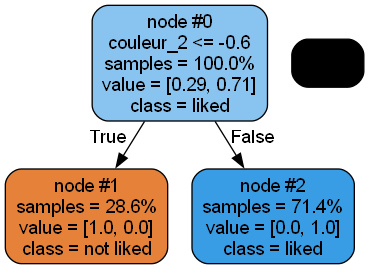

Importance des variables :
1. couleur_2 (1.000000)
2. tag (0.000000)
3. couleur_1 (0.000000)
4. format (0.000000)
5. orientation (0.000000)
6. size (0.000000)
[0 0]


In [22]:

import os
import sys
import json
import urllib
import shutil
import random
import time
import pandas as pd
import webcolors
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.colors as mcl
from SPARQLWrapper import SPARQLWrapper, JSON
from PIL import Image
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import graphviz
import pydotplus
from urllib.error import HTTPError
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataFrame, resultframe, test_size=0.2, random_state=69)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Entraînement du modèle
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

# Évaluation du modèle
y_pred = dtc.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=1))

# Affichage de l'arbre de décision
dot_data = tree.export_graphviz(
    dtc, 
    out_file=None,
    filled=True, 
    rounded=True,
    class_names=le7.inverse_transform(resultframe.liked.unique()),
    feature_names=dataFrame.columns,
    proportion=True,
    impurity=False,
    precision=2,
    node_ids=True
) 

graph = graphviz.Source(dot_data) 
pydot_graph = pydotplus.graph_from_dot_data(dot_data)

import io

img = Image.open(io.BytesIO(pydot_graph.create_png()))
display(img)

# Affichage de l'importance des variables
importances = dtc.feature_importances_
indices = np.argsort(importances)[::-1]
print("Importance des variables :")
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, dataFrame.columns[indices[f]], importances[indices[f]]))
    
    
print(y_pred)

In [23]:
# Entraînement du modèle
rfc = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=69)
rfc.fit(X_train, y_train.to_numpy().ravel())

# Évaluation du modèle
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=1))

# Affichage de l'importance des variables
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
print("Importance des variables :")
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, dataFrame.columns[indices[f]], importances[indices[f]]))
    
    
print(y_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Importance des variables :
1. couleur_2 (0.334648)
2. tag (0.260446)
3. couleur_1 (0.259178)
4. orientation (0.075369)
5. size (0.059675)
6. format (0.010683)
[0 0]


#Data Visualization 

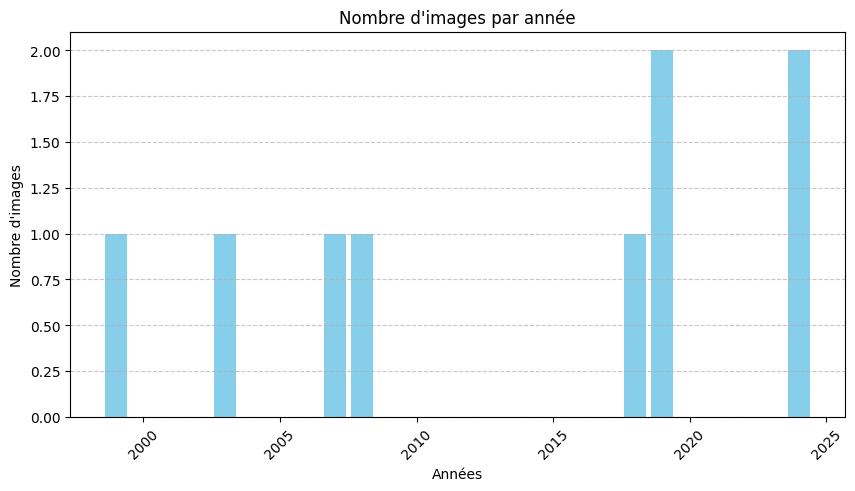

In [12]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Charger les données JSON
with open('img_data.json', 'r') as f:
    data = json.load(f)

# Convertir les données en DataFrame
df = pd.DataFrame(data).T  # Transpose pour que les IDs deviennent des lignes

    # Grouper par année et compter le nombre d'images
nb_images_year = df.groupby("date").size()

    # Tracer l'histogramme
plt.figure(figsize=(10, 5))
plt.bar(nb_images_year.index, nb_images_year.values, color='skyblue')
plt.title("Nombre d'images par année")
plt.xlabel("Années")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()




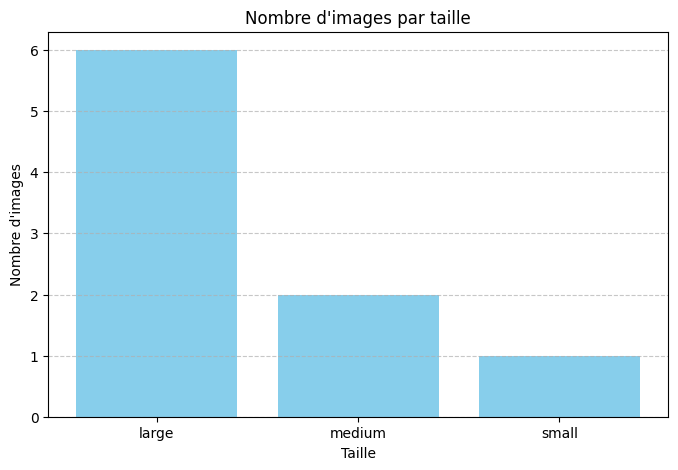

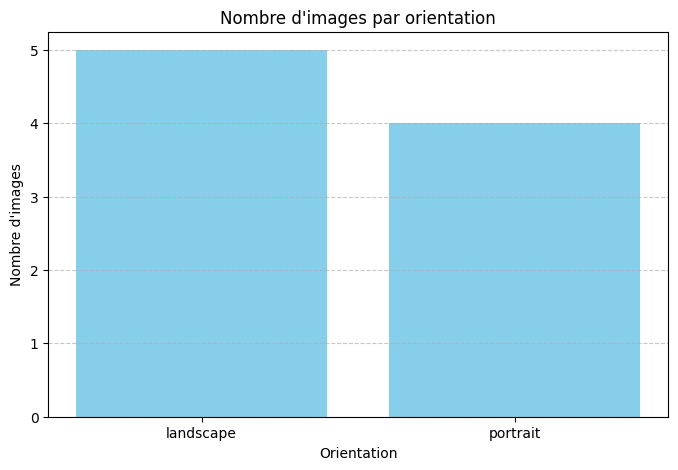

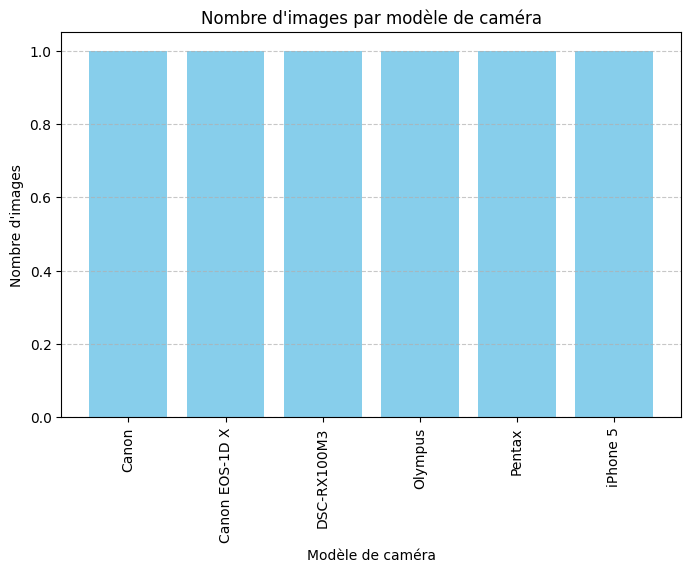

In [13]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Charger les données JSON
with open('img_data.json', 'r') as f:
    data = json.load(f)

# Convertir en DataFrame
df = pd.DataFrame(data).T  # Transpose pour que les IDs deviennent des lignes


# Fonctions pour tracer les histogrammes
def plot_bar(data, title, xlabel, ylabel, rotation=0):
    plt.figure(figsize=(8, 5))
    plt.bar(data.index, data.values, color='skyblue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()


nb_images_size = df.groupby("size").size()
plot_bar(nb_images_size, "Nombre d'images par taille", "Taille", "Nombre d'images")


nb_images_orientation = df.groupby("orientation").size()
plot_bar(nb_images_orientation, "Nombre d'images par orientation", "Orientation", "Nombre d'images")

nb_images_camera = df[df["model"] != "Unknown"].groupby("model").size()
plot_bar(nb_images_camera, "Nombre d'images par modèle de caméra", "Modèle de caméra", "Nombre d'images", rotation=90)


# Color Characteristics
## En 2D 

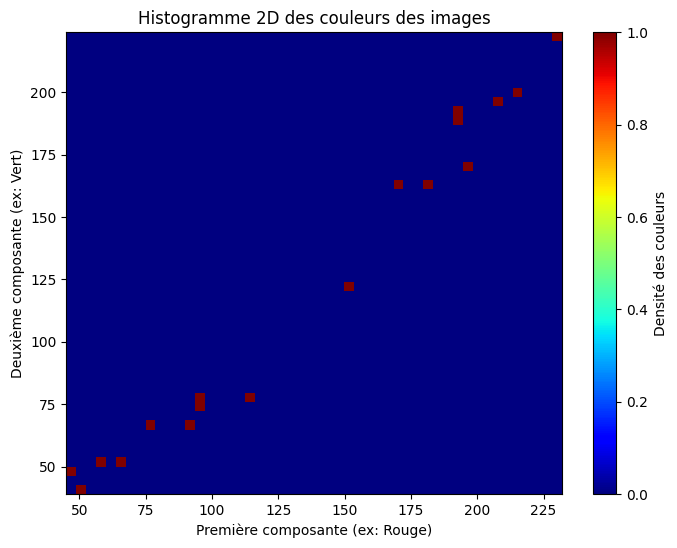

In [14]:


# Initialiser une liste pour stocker toutes les couleurs
import json
import numpy as np
import matplotlib.pyplot as plt

# Charger les données JSON
with open('img_data.json', 'r') as f:
    data = json.load(f)

# Extraire toutes les couleurs
all_colors = [color for image in data for color in data[image].get("colors", [])]

# Convertir en tableau NumPy
all_colors = np.array(all_colors)

# Créer un histogramme 2D des couleurs
plt.figure(figsize=(8, 6))
plt.hist2d(all_colors[:, 0], all_colors[:, 1], bins=50, cmap="jet")
plt.colorbar(label="Densité des couleurs")
plt.xlabel("Première composante (ex: Rouge)")
plt.ylabel("Deuxième composante (ex: Vert)")
plt.title("Histogramme 2D des couleurs des images")
plt.show()



## En 3D mais avec toutes les couleurs de chaques images

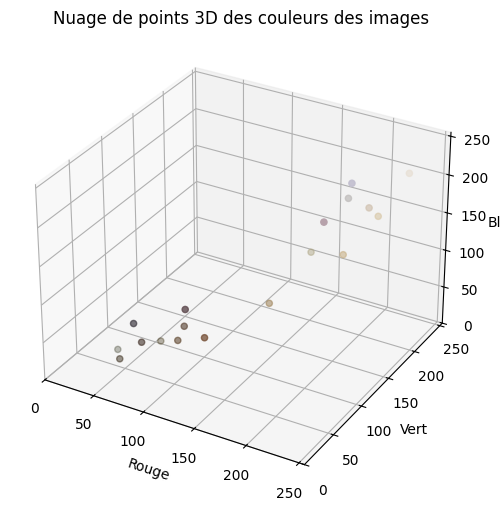

In [15]:
import json
import matplotlib.pyplot as plt
import matplotlib.colors as mcl
from mpl_toolkits.mplot3d import Axes3D

# Charger les données JSON
with open('img_data.json', 'r') as f:
    data = json.load(f)

# Initialiser les listes de coordonnées et de couleurs
x, y, z, colors = [], [], [], []

# Extraire les couleurs et les convertir en RGB + hex
for image in data:
    for color in data[image].get("colors", []):  # Récupère les couleurs ou [] si absent
        r, g, b = color
        x.append(r)
        y.append(g)
        z.append(b)
        colors.append(mcl.to_hex([r/255, g/255, b/255]))  # Conversion hex

# Création d'un graphique 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Ajouter les points avec leurs couleurs réelles
ax.scatter(x, y, z, c=colors, marker='o', s=20)  # Taille ajustée

# Ajouter des labels et fixer les limites des axes
ax.set_xlabel('Rouge')
ax.set_ylabel('Vert')
ax.set_zlabel('Bleu')
ax.set_xlim(0, 255)
ax.set_ylim(0, 255)
ax.set_zlim(0, 255)
ax.set_title("Nuage de points 3D des couleurs des images")

# Afficher le graphique
plt.show()


# Recommendation System

## 1- Sur une image

In [25]:
# Prédiction sur une image au hasard:
dataFrame = pd.read_json('img_data.json').T

ligne_aleatoire = dataFrame.sample()

ligne_aleatoire





,size,orientation,format,colors,date,model,tags
Q21002371-Q144,medium,landscape,JPEG,"[[58, 53, 62], [183, 162, 171]]",2007,Unknown,[dog]


In [26]:
ligne_aleatoire = prepData(ligne_aleatoire)

new_data = scaler.transform(ligne_aleatoire) # normalisation des données
y_pred = rfc.predict(new_data) # prédiction

# Affichage des prédictions
print(y_pred)

[0]


## 2- Sur toutes nos données

In [27]:

dataFrame = pd.read_json('img_data.json').T

dataFrame = prepData(dataFrame)

new_data = scaler.transform(dataFrame) # normalisation des données
y_pred = rfc.predict(new_data) # prédiction

# Affichage des prédictions
print(y_pred) #1 = Oui, 0 = non

[1 1 1 1 0 0 0 1 0]


In [28]:
resultats = []

for i,resultat in enumerate(y_pred):
    if resultat == 1:
        resultats.append(dataFrame.index[i])

print(f"Les images pouvant plaires a l'utilisateur 1 sont les suivante: \n{resultats}")

Les images pouvant plaires a l'utilisateur 1 sont les suivante: 
['Q210277-Q3305213', 'Q211293-Q3305213', 'Q212616-Q3305213', 'Q219271-Q3305213', 'Q21002371-Q144']


# Tests avec Unittest

In [20]:
import unittest
import json
from datetime import datetime

# Test suite for verifying various attributes of images
class TestImageAttributes(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        with open('img_data.json') as file:
            cls.img_data = json.load(file)

    def test_images_downloaded(self):
         # Test to ensure each image has at least one expected category tag
        expected_categories = {'dog', 'flag', 'island', 'sandwich', 'painting'}
        for image_id, attributes in self.img_data.items():
            tags = set(attributes.get('tags', []))
            # Vérifie si au moins une des catégories attendues se trouve dans les tags de l'image
            self.assertTrue(any(tag in tags for tag in expected_categories), f"Échec pour {image_id}: aucune catégorie correspondante trouvée parmi {tags}")


    def test_colors(self):
         # Test to ensure color values are in the correct format
        for image_id, attributes in self.img_data.items():
            colors = attributes.get('colors', [])
            for color in colors:
                self.assertEqual(len(color), 3, f"Échec pour {image_id}: couleur non conforme {color}")
                for value in color:
                    self.assertTrue(0 <= value <= 255, f"Échec pour {image_id}: valeur de couleur invalide {value}")

    def test_orientation_size_model(self):
        # Test to check if orientation, size, and model are valid
        for image_id, attributes in self.img_data.items():
            orientation = attributes.get('orientation')
            size = attributes.get('size')
            model = attributes.get('model')
            self.assertIn(orientation, ['portrait', 'landscape', 'squared'], f"Échec pour {image_id}: orientation invalide {orientation}")
            self.assertIn(size, ['small', 'medium', 'large'], f"Échec pour {image_id}: taille invalide {size}")
            self.assertIsInstance(model, str, f"Échec pour {image_id}: modèle invalide {model}")

    def test_valid_sizes(self):
        # Test to check if image sizes are within a set of valid sizes
        valid_sizes = {'small', 'medium', 'large'}
        for image_id, attributes in self.img_data.items():
            size = attributes.get('size')
            self.assertIn(size, valid_sizes, f"Échec pour {image_id}: taille invalide {size}")

    def test_valid_orientations(self):
        # Test to check if image orientations are within a set of valid orientations
        valid_orientations = {'portrait', 'landscape', 'squared'}
        for image_id, attributes in self.img_data.items():
            orientation = attributes.get('orientation')
            self.assertIn(orientation, valid_orientations, f"Échec pour {image_id}: orientation invalide {orientation}")

    def test_valid_formats(self):
        # Test to check if image formats are within a set of valid formats
        valid_formats = {'JPEG', 'PNG', 'TIFF', 'MPO'}
        for image_id, attributes in self.img_data.items():
            format = attributes.get('format')
            self.assertIn(format, valid_formats, f"Échec pour {image_id}: format invalide {format}")

    def test_valid_dates(self):
        # Test to ensure the date is within an acceptable range
        for image_id, attributes in self.img_data.items():
            date = attributes.get('date')
            self.assertIsInstance(date, int, f"Échec pour {image_id}: date invalide {date}")
            self.assertTrue(1990 <= date <= 2024, f"Échec pour {image_id}: date hors plage {date}")

    def test_valid_models(self):
        # Test to check if camera models are valid strings
        for image_id, attributes in self.img_data.items():
            model = attributes.get('model')
            self.assertIsInstance(model, str, f"Échec pour {image_id}: modèle invalide {model}")

    def test_valid_and_temporally_consistent_dates(self):
        # Test to ensure the dates are valid and consistent with expected technology timelines
        earliest_acceptable_year = 1990  # Ajustez selon le contexte technologique pertinent
        current_year = datetime.now().year
        for image_id, attributes in self.img_data.items():
            date = attributes.get('date')
            self.assertIsInstance(date, int, f"Échec pour {image_id}: date invalide {date}")
            self.assertTrue(earliest_acceptable_year <= date <= current_year, 
                            f"Échec pour {image_id}: date hors plage {date} (attendu entre {earliest_acceptable_year} et {current_year})")


# Loading the test cases
test_loader = unittest.TestLoader()
test_suite = test_loader.loadTestsFromTestCase(TestImageAttributes)

# Running the tests
test_runner = unittest.TextTestRunner(verbosity=2)
test_runner.run(test_suite)

test_colors (__main__.TestImageAttributes.test_colors) ... ok
test_images_downloaded (__main__.TestImageAttributes.test_images_downloaded) ... ok
test_orientation_size_model (__main__.TestImageAttributes.test_orientation_size_model) ... ok
test_valid_and_temporally_consistent_dates (__main__.TestImageAttributes.test_valid_and_temporally_consistent_dates) ... ok
test_valid_dates (__main__.TestImageAttributes.test_valid_dates) ... ok
test_valid_formats (__main__.TestImageAttributes.test_valid_formats) ... ok
test_valid_models (__main__.TestImageAttributes.test_valid_models) ... ok
test_valid_orientations (__main__.TestImageAttributes.test_valid_orientations) ... ok
test_valid_sizes (__main__.TestImageAttributes.test_valid_sizes) ... ok

----------------------------------------------------------------------
Ran 9 tests in 0.007s

OK


<unittest.runner.TextTestResult run=9 errors=0 failures=0>